In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ast import literal_eval
from pygmo import hypervolume

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# use the seaborn whitegrid style
plt.style.use('seaborn-v0_8-whitegrid')

from experiments_helper import format_df_table, summarize_results, get_data_model, summarize_results_multi

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def methods_naming(name):
    if "p2ce" in name:
        return "P$^2$CE"
    elif "mapocam" in name:
        return "MAPOCAM"
    elif "dice" in name:                                
        return "DICE"
    elif "nice" in name:
        return "NICE"
    else:
        return name
    

def methods_coloring(name):
    if "p2ce" in name:
        return "#66c2a5"
    elif "mapocam" in name:
        return "#fc8d62"
    elif "dice" in name:
        return "#80b1d3"
    elif "nice" in name:
        return "#984ea3"
    else:
        return "#ff0000"
    
def dataset_naming(name):
    if name == "german":
        return "German Credit"
    elif name == "taiwan":
        return "Taiwan"
    elif name == "adult":
        return "Adult"
    elif name == "acsincome":
        return "ACSIncome"
    elif name == "homecredit":
        return "HomeCredit"
    else:
        return name

In [3]:
def plot_test(results, axs):
    outliers_ = []
    method_list = results.method.unique()
    min_x, max_x, min_y, max_y = np.inf, -np.inf, np.inf, -np.inf
    for method in method_list:
        results_r = results[results.method == method]
        x_mean = results_r.time.mean()
        y_mean = results_r.costs.mean()
        outliers_.append(results_r.outlier.mean())

        min_x = min(min_x, x_mean)
        max_x = max(max_x, x_mean)
        min_y = min(min_y, y_mean)
        max_y = max(max_y, y_mean)

        x_05 = x_mean - np.quantile(results_r.time, 0.05)
        x_95 = np.quantile(results_r.time, 0.95) - x_mean
        y_05 = y_mean - np.quantile(results_r.costs, 0.05)
        y_95 = np.quantile(results_r.costs, 0.95) - y_mean

        # clip at 0
        x_05 = min(x_05, x_mean)
        y_05 = min(y_05, y_mean)

        x_05 = results_r.time.std()
        x_95 = results_r.time.std()
        y_05 = results_r.costs.std()
        y_95 = results_r.costs.std()


        axs[0].scatter(
            x_mean, 
            y_mean, 
            label = methods_naming(method), 
            c = methods_coloring(method),
            zorder = 100 if "p2ce" in method else 2,
        )
        axs[0].errorbar(
            [x_mean],
            [y_mean],
            xerr = [[x_05], [x_95]],
            yerr = [[y_05], [y_95]],
            label = methods_naming(method),
            c = methods_coloring(method),
            zorder = 100 if "p2ce" in method else 2,
        )

    x_pad = (max_x - min_x) * 0.1
    y_pad = (max_y - min_y) * 0.1
    #axs[0].set_xlim(min_x - x_pad, max_x + x_pad)
    #axs[0].set_ylim(min_y - y_pad, max_y + y_pad)

    handles = [
        Line2D(
            [0],
            [0],
            marker = "o",
            color = "w",
            markerfacecolor =  methods_coloring(name),
            markersize = 10,
            label = methods_naming(name),
        ) for name in method_list
    ]
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Average Continuous Dist.")


    axs[1].barh(
        [methods_naming(name) for name in method_list],
        [o * 100 for o in outliers_],
        color = [methods_coloring(name) for name in method_list],
    )
    axs[1].set_xlabel("% Outliers")

## Ablation experiment

In [12]:
method_list = ["p2ce_abs_diff", "p2ce_ablation_abs_diff", "mapocam_abs_diff"]

def show_results(dataset_name, method_list):
    results = []
    for method in method_list:
        results_cur = pd.read_csv(f"../results/lr/{dataset_name}/{method}.csv")
        results_cur = summarize_results(results_cur, dataset_name)
        results_cur["method"] = method
        results.append(results_cur)
    results = pd.concat(results)
    return format_df_table(results, "method", results.columns.tolist()[:-1])

In [13]:
show_results("german", method_list)[["method", "abs_diff_costs", "outlier", "time"]]

,method,abs_diff_costs,outlier,time
0,mapocam_abs_diff,0.126 ($\pm$0.1),0.029 ($\pm$0.2),12.659 ($\pm$8.8)
1,p2ce_ablation_abs_diff,0.126 ($\pm$0.1),0.012 ($\pm$0.1),11.317 ($\pm$7.7)
2,p2ce_abs_diff,0.125 ($\pm$0.1),0.012 ($\pm$0.1),14.471 ($\pm$10.3)


In [14]:
show_results("taiwan", method_list)[["method", "abs_diff_costs", "outlier", "time"]]

,method,abs_diff_costs,outlier,time
0,mapocam_abs_diff,0.29 ($\pm$0.1),0.03 ($\pm$0.2),36.401 ($\pm$33.9)
1,p2ce_ablation_abs_diff,0.292 ($\pm$0.1),0.016 ($\pm$0.1),38.309 ($\pm$35.1)
2,p2ce_abs_diff,0.292 ($\pm$0.1),0.016 ($\pm$0.1),14.022 ($\pm$8.5)


In [15]:
show_results("adult", method_list)[["method", "abs_diff_costs", "outlier", "time"]]

,method,abs_diff_costs,outlier,time
0,mapocam_abs_diff,0.129 ($\pm$0.1),0.22 ($\pm$0.4),1.455 ($\pm$1.0)
1,p2ce_ablation_abs_diff,0.171 ($\pm$0.1),0.058 ($\pm$0.2),2.124 ($\pm$3.9)
2,p2ce_abs_diff,0.179 ($\pm$0.1),0.028 ($\pm$0.2),1.317 ($\pm$1.5)


## Comparative experiment

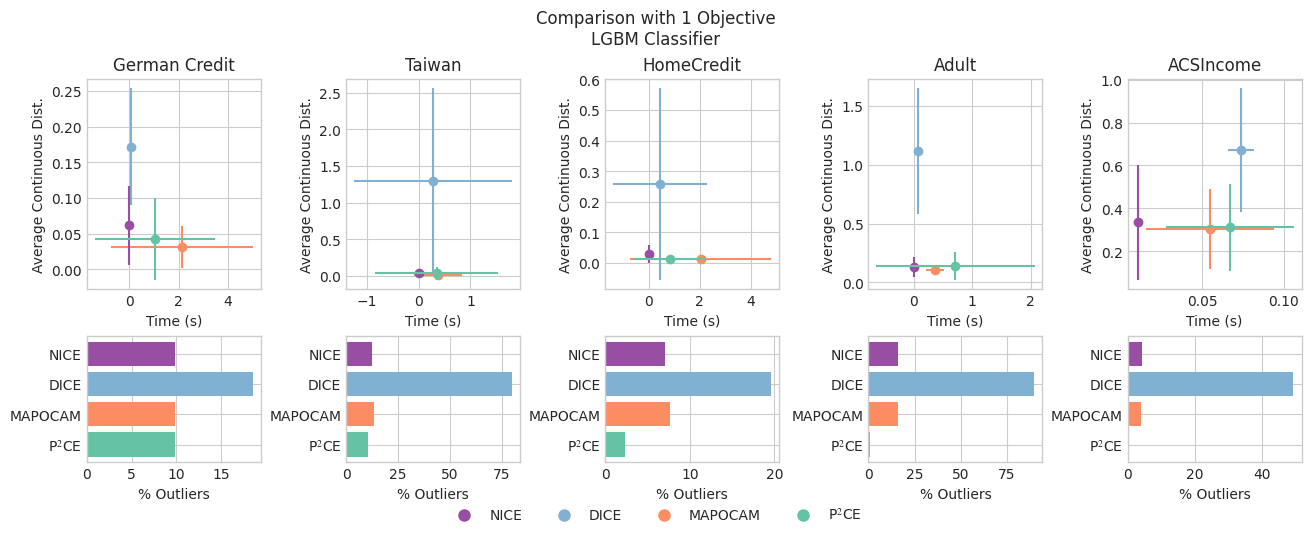

In [39]:
fig = plt.figure(figsize = (13, 5), layout = "constrained")
axs = fig.subplots(nrows = 2, ncols = 5, height_ratios=[1, 0.6])

#  "taiwan",
#"homecredit", "acsincome"

model = "lgbm"
for i, dataset_name in enumerate(["german", "taiwan","homecredit", "adult", "acsincome"]):
        method_list = ["p2ce_tree_abs_diff", "mapocam_tree_abs_diff", "dice", "nice"]

        results = []

        for method in method_list:
            try:
                results_cur = pd.read_csv(f"../results/{model}/{dataset_name}/{method}.csv")
                results_cur = summarize_results(results_cur, dataset_name)

                if "p2ce" in method:
                    method = "p2ce_abs_diff"
                if "mapocam" in method:
                    method = "mapocam_abs_diff"
                    
                results_cur["method"] = method
                results.append(results_cur)
            except:
                pass
        
        try:
            results = pd.concat(results)
        except:
            continue
        
        results = results.dropna() # CHECK IF NEEDED

        results["costs"] = results["abs_diff_costs"]
        axs_ = [axs[0][i], axs[1][i]]
        plot_test(results, axs_)

        axs[0][i].set_title(f"{dataset_naming(dataset_name)}")


plt.suptitle("Comparison with 1 Objective\nLGBM Classifier")

handles = [
    Line2D(
        [0],
        [0],
        marker = "o",
        color = "w",
        markerfacecolor =  methods_coloring(name),
        markersize = 10,
        label = methods_naming(name),
    ) for name in results.method.unique()
]
handles = handles[::-1]

fig.legend(
    handles = handles,
    loc = "lower center",
    ncol = len(handles),
    bbox_to_anchor = (0.5, -0.06),
)

plt.savefig("../figures/percentile_results_lgbm.pdf", dpi = 300)

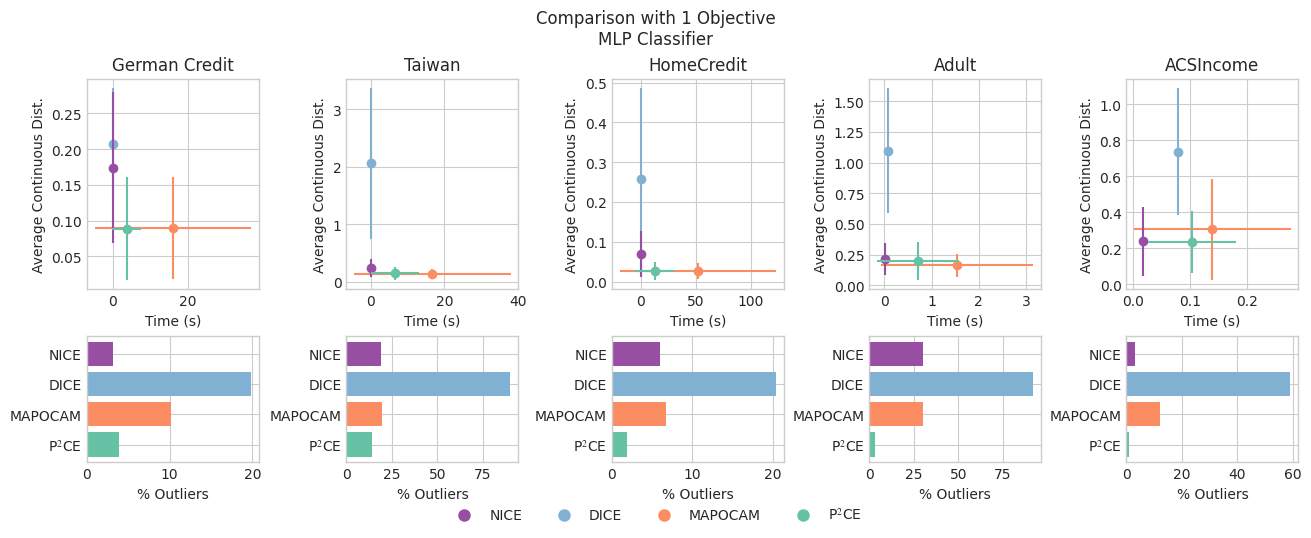

In [ ]:
fig = plt.figure(figsize = (13, 5), layout = "constrained")
axs = fig.subplots(nrows = 2, ncols = 5, height_ratios=[1, 0.6])

model = "mlp"

for i, dataset_name in enumerate(["german", "taiwan","homecredit", "adult", "acsincome"]):
        method_list = ["p2ce_deep_abs_diff", "mapocam_deep_abs_diff", "dice", "nice"]

        results = []

        for method in method_list:
            try:
                results_cur = pd.read_csv(f"../results/{model}/{dataset_name}/{method}.csv")
                results_cur = summarize_results(results_cur, dataset_name)

                if "p2ce" in method:
                    method = "p2ce_abs_diff"
                if "mapocam" in method:
                    method = "mapocam_abs_diff"
                    
                results_cur["method"] = method
                results.append(results_cur)
            except:
                pass
        
        try:
            results = pd.concat(results)
        except:
            continue
        
        results = results.dropna() # CHECK IF NEEDED

        results["costs"] = results["abs_diff_costs"]
        axs_ = [axs[0][i], axs[1][i]]
        plot_test(results, axs_)

        axs[0][i].set_title(f"{dataset_naming(dataset_name)}")


plt.suptitle("Comparison with 1 Objective\nMLP Classifier")


handles = [
    Line2D(
        [0],
        [0],
        marker = "o",
        color = "w",
        markerfacecolor =  methods_coloring(name),
        markersize = 10,
        label = methods_naming(name),
    ) for name in results.method.unique()
]
handles = handles[::-1]

fig.legend(
    handles = handles,
    loc = "lower center",
    ncol = len(handles),
    bbox_to_anchor = (0.5, -0.06),
)

plt.savefig("../figures/percentile_results_mlp.pdf", dpi = 300)

## Comaparison with multiple objectives

In [62]:
dataset = "german"
method_list = ["mapocam_tree_multi", "p2ce_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.321 ($\pm$0.5),0.099 ($\pm$0.0)
1,mapocam_tree_multi,0.099 ($\pm$0.3),2.969 ($\pm$4.0)
2,p2ce_tree_multi,0.099 ($\pm$0.3),1.49 ($\pm$3.3)


In [63]:
dataset = "german"
method_list = ["mapocam_deep_multi", "p2ce_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.316 ($\pm$0.5),0.111 ($\pm$0.0)
1,mapocam_deep_multi,0.144 ($\pm$0.4),20.663 ($\pm$24.5)
2,p2ce_deep_multi,0.076 ($\pm$0.3),5.396 ($\pm$5.2)


In [64]:
dataset = "taiwan"
method_list = ["mapocam_tree_multi", "p2ce_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.99 ($\pm$0.1),0.423 ($\pm$2.2)
1,mapocam_tree_multi,0.152 ($\pm$0.4),0.653 ($\pm$1.1)
2,p2ce_tree_multi,0.116 ($\pm$0.3),0.567 ($\pm$1.9)


In [65]:
dataset = "taiwan"
method_list = ["mapocam_deep_multi", "p2ce_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.968 ($\pm$0.2),0.563 ($\pm$3.1)
1,mapocam_deep_multi,0.32 ($\pm$0.5),21.617 ($\pm$28.5)
2,p2ce_deep_multi,0.245 ($\pm$0.4),4.963 ($\pm$4.0)


In [66]:
dataset = "homecredit"
method_list = ["mapocam_tree_multi", "p2ce_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.366 ($\pm$0.5),1.278 ($\pm$3.9)
1,mapocam_tree_multi,0.082 ($\pm$0.3),3.424 ($\pm$5.0)
2,p2ce_tree_multi,0.025 ($\pm$0.2),1.328 ($\pm$2.2)


In [67]:
dataset = "homecredit"
method_list = ["mapocam_deep_multi", "p2ce_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.4 ($\pm$0.5),1.077 ($\pm$4.4)
1,mapocam_deep_multi,0.074 ($\pm$0.3),105.85 ($\pm$142.8)
2,p2ce_deep_multi,0.023 ($\pm$0.1),15.096 ($\pm$23.3)


In [68]:
dataset = "adult"
method_list = ["mapocam_tree_multi", "p2ce_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.996 ($\pm$0.1),0.084 ($\pm$0.0)
1,mapocam_tree_multi,0.176 ($\pm$0.4),0.458 ($\pm$0.2)
2,p2ce_tree_multi,0.009 ($\pm$0.1),0.588 ($\pm$1.0)


In [69]:
dataset = "adult"
method_list = ["mapocam_deep_multi", "p2ce_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.988 ($\pm$0.1),0.091 ($\pm$0.0)
1,mapocam_deep_multi,0.326 ($\pm$0.5),2.109 ($\pm$2.0)
2,p2ce_deep_multi,0.047 ($\pm$0.2),2.296 ($\pm$2.0)


In [70]:
dataset = "acsincome"
method_list = ["mapocam_tree_multi", "p2ce_tree_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/lgbm/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.901 ($\pm$0.3),0.086 ($\pm$0.0)
1,mapocam_tree_multi,0.04 ($\pm$0.2),0.056 ($\pm$0.0)
2,p2ce_tree_multi,0.005 ($\pm$0.1),0.046 ($\pm$0.0)


In [71]:
dataset = "acsincome"
method_list = ["mapocam_deep_multi", "p2ce_deep_multi", "dice_multi"]
results = []
for method in method_list:
    results_cur = pd.read_csv(f"../results/mlp/{dataset}/{method}.csv")
    results_cur = summarize_results(results_cur, dataset)
    results_cur["method"] = method
    results.append(results_cur)
results = pd.concat(results)
format_df_table(results, "method", results.columns.tolist()[:-1])[["method", "outlier", "time"]]

,method,outlier,time
0,dice_multi,0.918 ($\pm$0.3),0.099 ($\pm$0.0)
1,mapocam_deep_multi,0.13 ($\pm$0.3),0.217 ($\pm$0.2)
2,p2ce_deep_multi,0.013 ($\pm$0.1),0.103 ($\pm$0.1)


In [72]:
def remove_dominated_solutions(A):
    """From a list of costs, keep only the non-dominated solutions."""
    non_dominated = []
    for i, s1 in enumerate(A):
        dominated = False
        for j, s2 in enumerate(A):
            if i == j:
                continue
            if all(s2 <= s1):
                if (s1 - s2).sum() < 1e-8:
                    # are the same solution
                    continue

                dominated = True
                break
        if not dominated:
            non_dominated.append(s1)

    return non_dominated

In [73]:
def get_experiments_multi_costs(
    dataset_name,
    method_name,
    model_name,
    keep_dominated = False
):  
    """Get the costs of the experiments for a multi-objective method.
    It will return an list of numpy arrays, where each array contains the costs of the solutions for an individual.
    """
    results = pd.read_csv(f"../results/{model_name}/{dataset_name}/{method_name}.csv")
    results = summarize_results_multi(results, dataset_name)
    costs = results[["abs_diff_costs", "max_dist_costs", "n_changes"]].values
    costs = costs.tolist()
    costs = [np.array(list(zip(*c))) for c in costs]
    if not keep_dominated:
        costs = [remove_dominated_solutions(c) for c in costs]
    return costs

In [75]:
results = []
for dataset in ["german", "taiwan", "homecredit", "adult", "acsincome"]:
    costs = {}
    method_list = ["p2ce_tree_multi", "mapocam_tree_multi",  "dice_multi"]
    for method in method_list:
        costs[method] = get_experiments_multi_costs(dataset, method, "lgbm", keep_dominated = False)


    # get maximum cost for each objective
    max_costs = np.ones(len(costs[method][0][0])) * -np.inf

    for method in method_list:
        for i in range(50): # for each individual
            if len(costs[method][i]) == 0:
                continue
            max_costs = np.maximum(max_costs, np.max(costs[method][i], axis = 0))

    
    # calculate hypervolume of each method
    for method in method_list:
        for i in range(50):
            if len(costs[method][i]) == 0:
                hv = 0
            else:
                costs_ = costs[method][i]
                costs_ /= max_costs
                hv = hypervolume(costs_).compute(np.ones(len(max_costs)))

            results.append([dataset, method, i, hv])
results = pd.DataFrame(results, columns = ["dataset", "method", "individual", "hv"])

def make_table(df):
    hv_mean = df["hv"].mean().round(2)
    hv_std = df["hv"].std().round(2)
    return f"{hv_mean} ($\pm$ {hv_std})"
results.groupby(["dataset", "method"]).apply(make_table)

dataset     method            
acsincome   dice_multi            0.17 ($\pm$ 0.19)
            mapocam_tree_multi    0.25 ($\pm$ 0.21)
            p2ce_tree_multi       0.25 ($\pm$ 0.22)
adult       dice_multi            0.28 ($\pm$ 0.14)
            mapocam_tree_multi    0.59 ($\pm$ 0.03)
            p2ce_tree_multi       0.53 ($\pm$ 0.16)
german      dice_multi            0.26 ($\pm$ 0.17)
            mapocam_tree_multi    0.49 ($\pm$ 0.15)
            p2ce_tree_multi       0.48 ($\pm$ 0.17)
homecredit  dice_multi            0.46 ($\pm$ 0.14)
            mapocam_tree_multi    0.62 ($\pm$ 0.08)
            p2ce_tree_multi       0.62 ($\pm$ 0.08)
taiwan      dice_multi            0.42 ($\pm$ 0.17)
            mapocam_tree_multi    0.64 ($\pm$ 0.07)
            p2ce_tree_multi       0.61 ($\pm$ 0.12)
dtype: object

In [76]:
results = []
#for dataset in ["german", "taiwan", "adult"]:
for dataset in ["german", "taiwan", "homecredit", "adult", "acsincome"]:
    costs = {}
    method_list = ["p2ce_deep_multi", "mapocam_deep_multi",  "dice_multi"]
    for method in method_list:
        costs[method] = get_experiments_multi_costs(dataset, method, "mlp", keep_dominated = False)


    # get maximum cost for each objective
    max_costs = np.ones(len(costs[method][0][0])) * -np.inf

    for method in method_list:
        for i in range(50): # for each individual
            if len(costs[method][i]) == 0:
                continue
            max_costs = np.maximum(max_costs, np.max(costs[method][i], axis = 0))

    
    # calculate hypervolume of each method
    for method in method_list:
        for i in range(50):
            if len(costs[method][i]) == 0:
                hv = 0
            else:
                costs_ = costs[method][i]
                costs_ /= max_costs
                hv = hypervolume(costs_).compute(np.ones(len(max_costs)) + 1e-5)

            results.append([dataset, method, i, hv])
results = pd.DataFrame(results, columns = ["dataset", "method", "individual", "hv"])

def make_table(df):
    hv_mean = df["hv"].mean().round(2)
    hv_std = df["hv"].std().round(2)
    return f"{hv_mean} ($\pm$ {hv_std})"
results.groupby(["dataset", "method"]).apply(make_table)

dataset     method            
acsincome   dice_multi            0.26 ($\pm$ 0.19)
            mapocam_deep_multi    0.35 ($\pm$ 0.23)
            p2ce_deep_multi       0.35 ($\pm$ 0.24)
adult       dice_multi             0.3 ($\pm$ 0.14)
            mapocam_deep_multi    0.55 ($\pm$ 0.09)
            p2ce_deep_multi        0.5 ($\pm$ 0.18)
german      dice_multi             0.2 ($\pm$ 0.15)
            mapocam_deep_multi    0.42 ($\pm$ 0.19)
            p2ce_deep_multi         0.4 ($\pm$ 0.2)
homecredit  dice_multi            0.33 ($\pm$ 0.14)
            mapocam_deep_multi    0.59 ($\pm$ 0.07)
            p2ce_deep_multi       0.54 ($\pm$ 0.17)
taiwan      dice_multi            0.35 ($\pm$ 0.16)
            mapocam_deep_multi      0.6 ($\pm$ 0.1)
            p2ce_deep_multi       0.51 ($\pm$ 0.23)
dtype: object

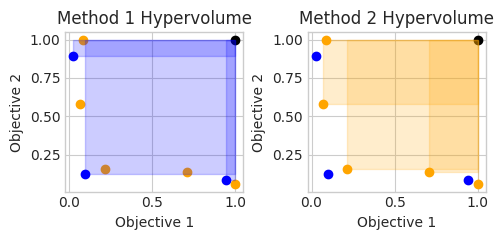

In [44]:
# create plot of hypervolumes

np.random.seed(0)

points_method_1 = np.random.rand(27, 2)
points_method_2 = np.random.rand(19, 2)

points_method_1 = remove_dominated_solutions(points_method_1)
points_method_2 = remove_dominated_solutions(points_method_2)

points_method_2 += [[0.05, 0.4]]
points_method_1 = np.array(points_method_1)
points_method_2 = np.array(points_method_2)


# get maximum for each axis
max_x = max(points_method_1[:, 0].max(), points_method_2[:, 0].max())
max_y = max(points_method_1[:, 1].max(), points_method_2[:, 1].max())

# normalze points
points_method_1[:, 0] /= max_x
points_method_1[:, 1] /= max_y
points_method_2[:, 0] /= max_x
points_method_2[:, 1] /= max_y

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (5, 2.5))

axs[0].scatter(points_method_1[:, 0], points_method_1[:, 1], label = "Method 1", c = "blue")
axs[0].scatter(points_method_2[:, 0], points_method_2[:, 1], label = "Method 2", c = "orange")

axs[1].scatter(points_method_2[:, 0], points_method_2[:, 1], label = "Method 2", c = "orange")
axs[1].scatter(points_method_1[:, 0], points_method_1[:, 1], label = "Method 1", c = "blue")


axs[0].scatter([1], [1], c = "black", label = "Reference Point")
axs[1].scatter([1], [1], c = "black", label = "Reference Point")

# for each point, draw a rectangle with the reference point
for p in points_method_1:
    axs[0].add_patch(
        plt.Rectangle(
            (p[0], p[1]),
            1 - p[0],
            1 - p[1],
            alpha = 0.2,
            color = "blue",
        )
    )

for p in points_method_2:
    axs[1].add_patch(
        plt.Rectangle(
            (p[0], p[1]),
            1 - p[0],
            1 - p[1],
            alpha = 0.2,
            color = "orange",
        )
    )


for i in range(2):
    axs[i].set_xlabel("Objective 1")
    axs[i].set_ylabel("Objective 2")
    

axs[0].set_title("Method 1 Hypervolume")
axs[1].set_title("Method 2 Hypervolume")
plt.tight_layout()

plt.savefig("../figures/hypervolume_example.pdf", dpi = 300)

## Example comparison of Counterfactual Explanations

In [24]:
i = 2
dataset_name = "taiwan"
SEED = 0
dataset, X_train, _, model, outlier_detection, individuals = get_data_model(dataset_name, "MLPClassifier")
individuals = individuals.sample(n = 500, random_state=SEED)

# get the solution of individual i for each method
method_list = ["p2ce_deep_multi", "mapocam_deep_multi", "dice_multi"]
df_temp = []
for method in method_list:
    results = pd.read_csv(f"../results/mlp/{dataset_name}/{method}.csv")

    solutions = literal_eval(results["solutions"].iloc[i])
    for s in solutions:
        s_df = pd.DataFrame([s], columns = X_train.columns.tolist())
        extra_columns = [
            method,
            outlier_detection.predict(np.array([s]))[0],
            model.predict_proba(s_df)[0, 1],
        ]
        df_temp.append(s + extra_columns)

extra_columns = [
    "individual",
    1,
    model.predict_proba(individuals.iloc[i:i+1])[0, 1],
]
df_temp.append(
    individuals.iloc[i].tolist() + extra_columns
)
df_temp = df_temp[::-1]
df_temp = pd.DataFrame(df_temp, columns = X_train.columns.tolist() + ["method", "outlier", "pred"])


In [34]:
def get_organized_explanations(individual, counterfactual_exp):
    """This function will output a list of explanations. Each explanation is another list of feature changes.

    Parameters
    ----------
    individual : pd.DataFrame
        DataFrame with only one row representing the individual
    counterfactual_exp : pd.DataFrame
        DataFrame with the counterfactual explanations
    """

    organized_exps = []
    for _, row in counterfactual_exp.iterrows():
        changes = []
        for col in individual.columns:
            if individual[col].iloc[0] != row[col]:
                changes.append((col, individual[col].iloc[0], row[col]))
        organized_exps.append(changes)
    return organized_exps

In [29]:
i = 2
dataset_name = "taiwan"
SEED = 0
dataset, X_train, _, model, outlier_detection, individuals = get_data_model(dataset_name, "MLPClassifier")
individuals = individuals.sample(n = 500, random_state=SEED)

# get the solution of individual i for each method
method_list = ["p2ce_deep_multi", "mapocam_deep_multi", "dice_multi"]
df_temp = []
for method in method_list:
    results = pd.read_csv(f"../results/mlp/{dataset_name}/{method}.csv")

    solutions = literal_eval(results["solutions"].iloc[i])
    solutions_df = []
    for s in solutions:
        s_df = pd.DataFrame([s], columns = X_train.columns.tolist())
        solutions_df.append(s_df)
    solutions_df = pd.concat(solutions_df)

In [36]:
organized_exp = get_organized_explanations(
    individuals.iloc[i:i+1],
    solutions_df
)

In [53]:
def transform_organized_explanations(organized_exp):
    transformed = []
    for i, exp in enumerate(organized_exp):
        new_exp = []
        for j, feature in enumerate(exp):
            transformed.append(
                (i, j,
                f"{feature[0]}\n {feature[1]} $\\rightarrow$ {feature[2]}" )
            )
        
    return transformed

In [119]:
def plot_text_squares(individual, counterfactual_exp, square_size = 1.0, margin = 0.1, title=""):
    
    side = square_size - (2 * margin)
    # individual is a data frame
    # counterfactual_exp is a data frame

    organized_exp = get_organized_explanations(individual, counterfactual_exp)
    features = [feature[0] for exp in organized_exp for feature in exp]
    features = list(set(features))

    # get unique color for each col
    cmap = plt.get_cmap("Pastel2")
    color_map = {text: cmap(k % 10) for k, text in enumerate(features)}

    # transform explanations to have positions
    transformed_exp = transform_organized_explanations(organized_exp)


    unique_x = sorted(list(set([d[0] for d in transformed_exp])))
    max_y = max([d[1] for d in transformed_exp])

    fig = plt.figure(figsize = (len(unique_x) * square_size * 2.5, (max_y + 1) * square_size * 2.5))
    ax = fig.add_subplot(1, 1, 1)

    for i, j, text in transformed_exp:
        x = i + margin
        y = j + margin


        # Create the square patch
        rect = patches.FancyBboxPatch(
            (x, y),
            side,
            side,
            linewidth=1,
            edgecolor="black",
            facecolor=color_map[text.split("\n")[0]],
            boxstyle='Round, pad=0, rounding_size=0.1',
            zorder=2,
        )
        ax.add_patch(rect)

        # Calculate center for the text
        cx = x + side / 2
        cy = y + side / 2
        ax.text(cx, cy, text, ha="center", va="center", fontweight="bold")


    unique_x = sorted(list(set([d[0] for d in transformed_exp])))
    max_y_for_x = {x: max([d[1] for d in transformed_exp if d[0] == x]) for x in unique_x}

    for x in unique_x:
        y = max_y_for_x[x] + 1
        border_rect = patches.FancyBboxPatch(
            (x + margin/2, margin/2),
            side + margin,
            y * square_size - margin/2,
            linewidth=1,
            facecolor="#cccccc",
            edgecolor="#909090",
            boxstyle='Round, pad=0, rounding_size=0.1',
            zorder=1,
        )
        ax.add_patch(border_rect)


    # Set limits and aspect
    ax.set_xlim(0, len(organized_exp) * square_size)
    ax.set_ylim(-0.1, max(len(exp) for exp in organized_exp) * square_size)
    #ax.set_aspect('equal')
    ax.axis('off')

    plt.suptitle(title)

p2ce_deep_multi
dice_multi


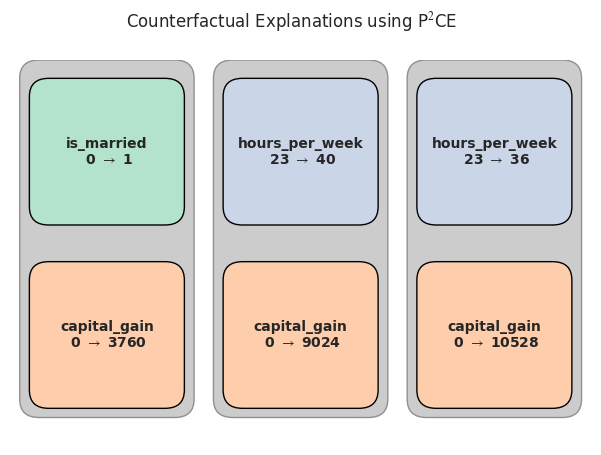

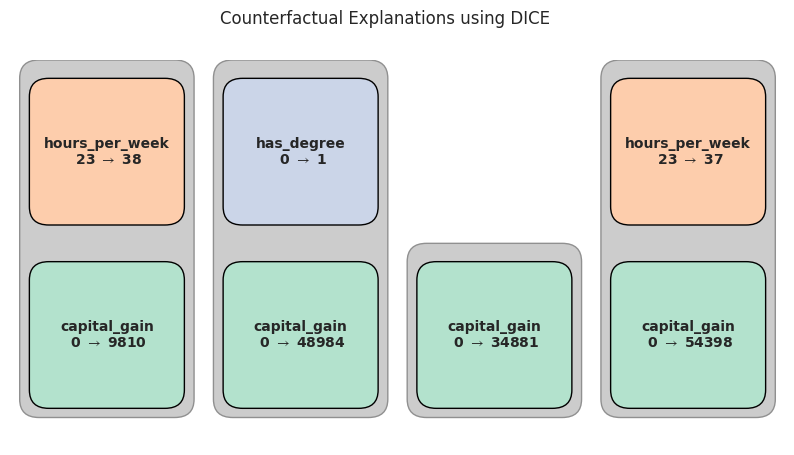

In [120]:
i = 14
dataset_name = "adult"
SEED = 0
dataset, X_train, _, model, outlier_detection, individuals = get_data_model(dataset_name, "MLPClassifier")
n = min(500, len(individuals))
individuals = individuals.sample(n = n, random_state=SEED)

# get the solution of individual i for each method
method_list = ["p2ce_deep_multi", "dice_multi"]
df_temp = []
for method in method_list:
    print(method)
    results = pd.read_csv(f"../results/mlp/{dataset_name}/{method}.csv")

    solutions = literal_eval(results["solutions"].iloc[i])
    solutions_df = []
    for s in solutions:
        s_df = pd.DataFrame([s], columns = X_train.columns.tolist())
        solutions_df.append(s_df)
    solutions_df = pd.concat(solutions_df)

    title = f"Counterfactual Explanations using {methods_naming(method)}"
    plot_text_squares(individuals.iloc[i:i+1], solutions_df, title=title)

    plt.savefig(f"../figures/eample_{method}.pdf", dpi = 300)


In [ ]:
dataset_name = "adult"
SEED = 0
dataset, X_train, _, model, outlier_detection, individuals = get_data_model(dataset_name, "MLPClassifier")
n = min(500, len(individuals))
individuals = individuals.sample(n = n, random_state=SEED)


for i in range(500):
    # get the solution of individual i for each method
    method_list = ["p2ce_deep_multi", "mapocam_deep_multi", "dice_multi"]
    df_temp = []
    n_solutions = {}
    for method in method_list:
        results = pd.read_csv(f"../results/mlp/{dataset_name}/{method}.csv")

        # solutions = literal_eval(results["solutions"].iloc[i])
        # solutions_df = []
        # for s in solutions:
        #     s_df = pd.DataFrame([s], columns = X_train.columns.tolist())
        #     solutions_df.append(s_df)
        #solutions_df = pd.concat(solutions_df)

        n_solutions[method] = results.iloc[i].n_solutions

    
    if (n_solutions["p2ce_deep_multi"] != n_solutions["mapocam_deep_multi"]) and (n_solutions["p2ce_deep_multi"] != n_solutions["dice_multi"]):
        print(i)



    #plot_text_squares(individuals.iloc[i:i+1], solutions_df)


0
3
11
14
16
17
20
28
33
34
41
46
50
52
53
54
57
60
63
64
65
68
76
77
80
82
83
85
86
87
88
91
92
95
96
97
100
105
108
109
113
118
124
132
133
138
139
143
144
145
148
149
158
159
165
166
171
175
179
180
185
191
192
195
197
200
205
206
207
211
214
216
221
222
223
226
227
229
231
241
243
247
249
253
254
266
270
274
282
283
285
288
289
291
292
293
294
296
297
299
309
312
317
324
326
327
328
332
335
342
343
345
346
348
352
353
354
360
363
365
371
372
374
377
378
379
381
388
390
394
395
397
398
401
408
413
414
416
421
424
427
429
430
432
435
437
439
440
443
444
449
452
456
457
458
459
462
463
465
466
467
473
476
477
478
479
486
488
491
492
493
494
496
